## 01: Estimate my chat response time
[insert intro]

In [138]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import scipy
import scipy.stats as stats
import scipy.optimize as opt
import statsmodels.api as sm

%matplotlib inline
plt.style.use('bmh')
colors = ['#348ABD', '#A60628', '#7A68A6', '#467821', '#D55E00', 
          '#CC79A7', '#56B4E9', '#009E73', '#F0E442', '#0072B2']

messages = pd.read_csv('data/hangout_chat_data.csv')

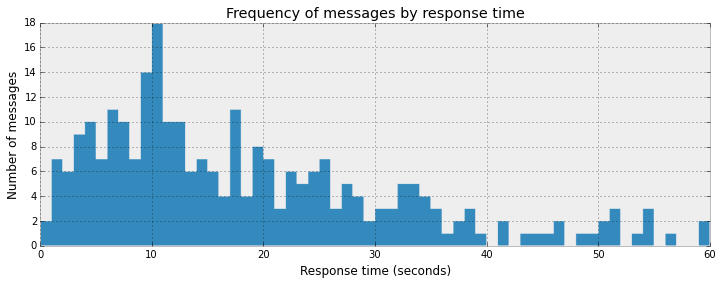

In [139]:
fig = plt.figure(figsize=(12,4))
_ = plt.title('Frequency of messages by response time')
_ = plt.xlabel('Response time (seconds)')
_ = plt.ylabel('Number of messages')
plt.hist(messages['time_delay_seconds'].values, range=[0, 60], bins=60, histtype='stepfilled')
plt.legend(label='', loc='right')

We first need to choose an appropriate distribution to model the above data. Given that `response_time` is count data, the Poisson distribution would be an appropriate choice. The Poisson distribution takes a parameter $\mu$ which represents both the distribution's mean and its variance. $\mu$ can take any non-negative integer.

Before we jump into Bayesian techniques, lets first look at one frequentist method of estimating the parameters of a poisson distribution. We will use an optimization technique that aims to maximize the likelihood of the a function.

The below function `poisson_logprob()` returns the overall likelihood of input data points given a poisson model parameter. The input data points are observed and hence cannot be changed. However, the poisson parameter can be changed and we use the optimization technique to maximize the likelihood of the model parameter given the observed data.

In [140]:
y_obs = messages['time_delay_seconds'].values

def poisson_logprob(mu):
    return -np.sum(stats.poisson.logpmf(y_obs, mu=mu))

freq_results = opt.minimize_scalar(poisson_logprob)
print "The estimated value of mu is: %s" % np.int(freq_results['x'])

The estimated value of mu is: 18


Interesting, so we estimate the value of $\mu$ (mean and variance of poisson distribution) to be 18. If we analytically plot the probability distribution of values from 0 to 60, we get the below distribution.

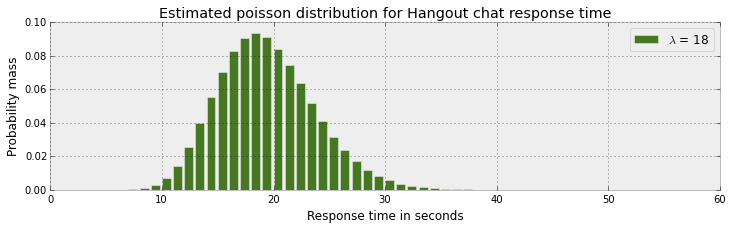

In [141]:
fig = plt.figure(figsize=(12,3))
ax = fig.add_subplot(111)
x_lim = 60
mu = np.int(freq_results['x'])
for i in np.arange(x_lim):
    plt.bar(i, stats.poisson.pmf(mu, i), color=colors[3])
    
_ = ax.set_xlim(0, x_lim)
_ = ax.set_ylim(0, 0.1)
_ = ax.set_xlabel('Response time in seconds')
_ = ax.set_ylabel('Probability mass')
_ = ax.set_title('Estimated poisson distribution for Hangout chat response time')
_ = plt.legend(['$\lambda$ = %s' % mu])

Bayesian techniques have some big advantages (and disadvantages) over the above frequentist technique. We'll explore some of these later. But first, lets estimate the value of $\mu$ by apply a Bayesian estimation technique called MCMC using the pythn library PYMC.

The Bayesian approach to estimating $\mu$ is different than that of Frequentists. To get a quick intro into the mechanics and theory behind MCMC, I recommend watching the below video by XXX.

Video

The below schematic is a Bayesian representation of the model we will estimate. [describe this DAG]

[insert schematic of model]

In [142]:
with pm.Model() as model:
    mu = pm.Uniform('mu', lower=0, upper=100)
    y_est = pm.Poisson('y_est', mu=mu, observed=messages['time_delay_seconds'].values)

    y_pred = pm.Poisson('y_pred', mu=mu) # ignore: we will talk about this later
    
    start = pm.find_MAP()
    step = pm.Metropolis()
    trace = pm.sample(20000, step, start=start, progressbar=True)

 [-----------------100%-----------------] 20000 of 20000 complete in 2.8 sec

### Posterior distribution of $\mu$
The below frequency plots represents 20,000 samples drawn from the posterior distribution of $\mu$. The plot on the left can be thought of as a histogram of these samples and the plot on the right is called the trace. It captures the sequential sampling of $\mu$ from 0 to 20,000.

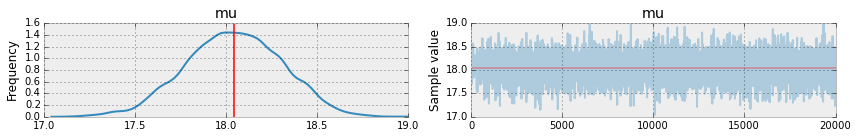

In [143]:
_ = pm.traceplot(trace, vars=['mu'], lines={'mu': freq_results['x']})

### Model convergence: autocorrelation plot
Comment on this

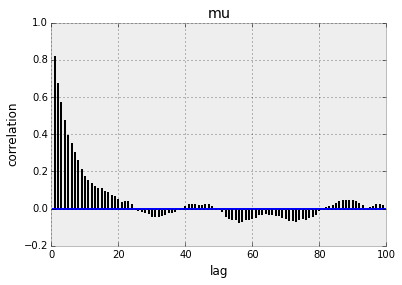

In [144]:
_ = pm.autocorrplot(trace[:2000], vars=['mu'])

In [145]:
# Apply pretty styles
from IPython.core.display import HTML

def css_styling():
    styles = open("styles/custom.css", "r").read()
    return HTML(styles)
css_styling()